# TeamBM5 Movie Recommendation 2023


<a id="cont"></a>

## Table of Content

<a href=#one>1. Introduction</a>

<a href=#two>2. Importing Libraries</a>

<a href=#three>3. Comet</a>

<a href=#four>4. Loading and inspecting the data</a>

<a href=#five>5. Exploratory Data Analysis</a>

<a href=#six>6. Data Preprocessing</a>

<a href=#seven>7. Feature Engineering</a>

<a href=#eight>8. Model Training and Evaluation</a>

<a href=#nine>9. Model Testing</a>

<a href=#ten>10. Saving The Model For Kaggle Submission</a>

<a href=#eleven>11. Saving The Models For Streamlit App</a>

<a href=#twelve>12. Conclusion</a>

<a href=#thirteen>13 Recommendations</a>

<a href=#fourteen>14. Reference Links</a>
    

 <a id="one"></a>
## 1. Introduction 
<a href=#cont>Back to Table of Contents</a>

<a id="two"></a>
## 2. Importing Libraries
<a href=#cont>Back to Table of Content

In [0]:
# Install packages here

# Package we need fore Comet
from comet_ml import Experiment

# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp

# Package for timing code
import timeit


# Packages for visualization
import matplotlib
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")


# Packages for modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import Reader
from surprise import Dataset
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD,NormalPredictor
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering,BaselineOnly
from sklearn.neighbors import  NearestNeighbors
import heapq

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Packages for Randomisation
import random
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (12,8)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

C:\Users\dell\AppData\Local\Temp\ipykernel_1680\3425999940.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-pastel')


<a id="three"></a>
## 3. Comet
<a href=#cont>Back to Table of Contents</a>

<a id="four"></a>
## 4. Loading and inspecting the data
<a href=#cont>Back to Table of Contents

In [2]:
# import dataset

genome_score = pd.read_csv('Dataset/genome_scores.csv')
genome_tags = pd.read_csv('Dataset/genome_tags.csv')
imdb_df = pd.read_csv('Dataset/imdb_data.csv')
links_df = pd.read_csv('Dataset/links.csv')
sample_submission_df = pd.read_csv('Dataset/sample_submission.csv')
tags_df = pd.read_csv('Dataset/tags.csv')
movies_df = pd.read_csv('Dataset/movies.csv')
test_df = pd.read_csv('Dataset/test.csv')
train_df = pd.read_csv('Dataset/train.csv')

We have the following datasets loaded above in same order:
* genome_scores.csv - a score mapping the strength between movies and tag-related properties.
* genome_tags.csv - user assigned tags for genome-related scores.
* imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
* links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
* sample_submission.csv - Sample of the submission format for the hackathon.
* tags.csv - User assigned for the movies within the dataset.
* movies.csv - Movie information is contained in this file
* test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
* train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

## Exploratory Data Analysis (EDA)

### Ratings and users

In [3]:
display(train_df.head(5))

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


None

In [5]:
print(train_df.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [6]:
test_df = pd.read_csv("Dataset/test.csv")
test_df.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [7]:
tags_df = pd.read_csv("Dataset/tags.csv")
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [9]:
genome_scores_df = pd.read_csv("Dataset/genome_scores.csv")
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [10]:
genome_tags_df = pd.read_csv("Dataset/genome_tags.csv")
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [11]:
imdb_df = pd.read_csv("Dataset/imdb_data.csv")
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [12]:
links_df = pd.read_csv("Dataset/links.csv")
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
movies_df = pd.read_csv("Dataset/movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
print("Total Train Data:")
print("Total number of movie ratings in Train data = "+str(train_df.shape[0]))
print("Number of unique users in Train data = "+str(len(np.unique(train_df["userId"]))))
print("Number of unique movies in Train data = "+str(len(np.unique(train_df["movieId"]))))
print("Highest value of a User ID = "+str(max(train_df["userId"].values)))
print("Highest value of a Movie ID = "+str(max(train_df["movieId"].values)))

Total Train Data:
Total number of movie ratings in Train data = 10000038
Number of unique users in Train data = 162541
Number of unique movies in Train data = 48213
Highest value of a User ID = 162541
Highest value of a Movie ID = 209171


In [15]:
# Count the number of unique entries for features of interest
unique_movies = len(movies_df['movieId'].unique().tolist())
unique_tags = len(tags_df['tag'].unique().tolist())
unique_users = len(train_df['userId'].unique().tolist())
unique_directors = len(imdb_df['director'].unique().tolist())
unique_actors = len(imdb_df['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

# Determine and display the min and max ratings received
min_rating = train_df.rating.min()
max_rating = train_df.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


Lowest rating: 0.5
Highest rating: 5.0


-- Which users have rated the most movies?

In [16]:
def user_ratings_count(df, n):
    """
    Counts the number of ratings for each user and creates a bar plot showing the top n users by the number of ratings.
    
    Parameters:
    df (DataFrame): Input DataFrame containing user ratings.
    n (int): Number of top users to display in the bar plot.
    """
    
    plt.figure(figsize=(8,6))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x=data.index, y=data, order=data.index, palette='Dark2', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t", df['userId'].value_counts().head(n).sum(),
          "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 38970 
Total number of movies:		 48213


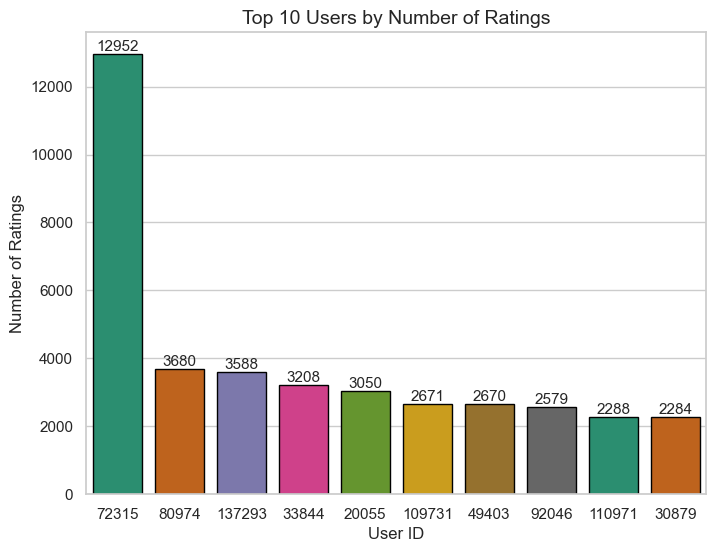

In [25]:
user_ratings_count(train_df,10)

The userid 72315 has rated movies the highest, this will be removed just for the purpose of EDA 

Combined number of ratings:	 28296 
Total number of movies:		 45844


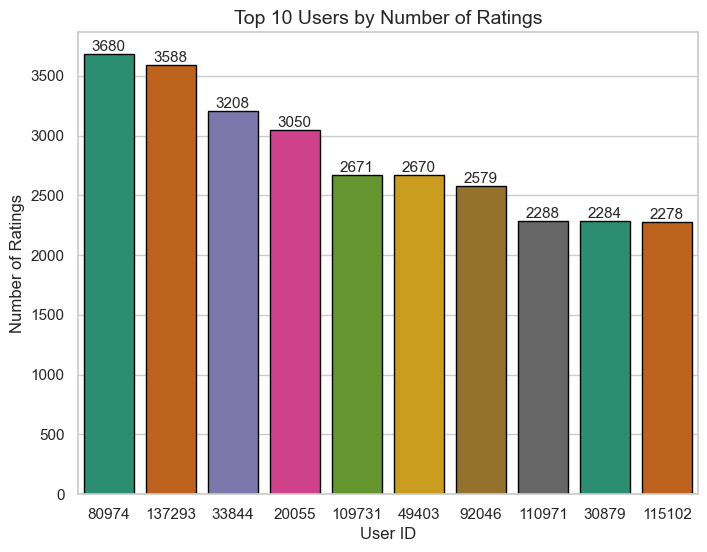

In [17]:
eda_df = train_df[train_df['userId']!=72315]
user_ratings_count(eda_df,10)

Lets examine how many ratings we dropped as a result of eliminating the outlier.

In [18]:
print("No of ratings lost:\t",34398-23734)
print("Movies rated by user 72315:\t",48213-45844)

No of ratings lost:	 10664
Movies rated by user 72315:	 2369


Lets view the distribution of ratings from worst to best?

In [19]:
def ratings_distplot(df, column='rating'):
    """
    Plots the distribution of ratings in the dataset.
    
    Parameters:
    df (DataFrame): Input DataFrame containing ratings.
    column (str, optional): Name of the column in the DataFrame that contains the ratings. Default is 'rating'.
    """
    
    plt.figure(figsize=(8, 6))
    ax = sns.distplot(df[column], bins=10, kde=False, hist_kws=dict(alpha=0.6), color="green")
    mean = df[column].mean()
    median = df[column].median()
    plt.axvline(x=mean, label=f'mean {round(mean, 2)}', color='green', lw=3, ls='--')
    plt.axvline(x=median, label=f'median {median}', color='#4DA017', lw=3, ls='--')
    plt.xlim((0.5, 5))
    plt.ylim((0, 2500000))
    plt.title('Distribution of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

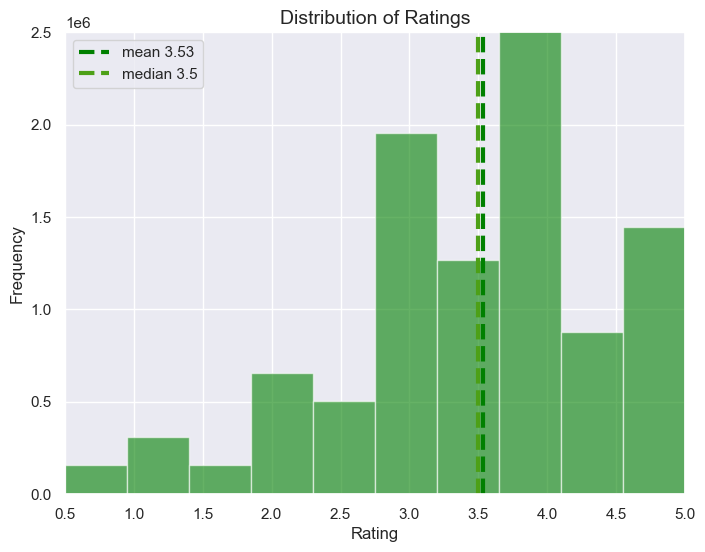

In [37]:
ratings_distplot(eda_df)

Lets look at the percentage of movies rated in each category using a donot chart?

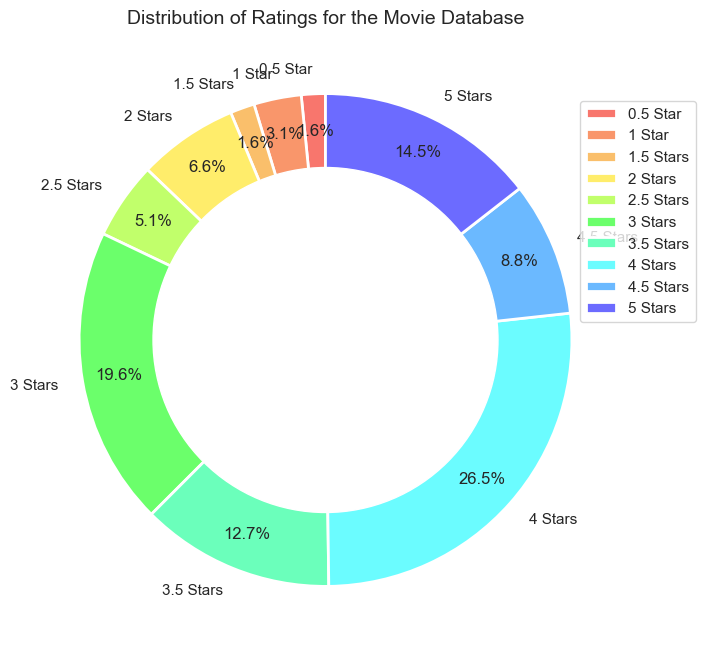

In [20]:
# Merge train with movies to join movie titles and ratings
ratings = train_df.merge(movies_df, on='movieId', how='inner')

# Count how many ratings are in each category
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title': 'rating_count'}, inplace=True)

# Creating plots
fig, ax = plt.subplots(figsize=(8, 8))

# Create color palette
labels = ['0.5 Star', '1 Star', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Stars', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
colors = ['#F8766D', '#F9966B', '#FABF6B', '#FFED6B', '#C1FF6B', '#6BFF6B', '#6BFFBB', '#6BFCFF', '#6BB9FF', '#6C6BFF']

# Create donut chart
donut = ax.pie(
    grouped['rating_count'],
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    pctdistance=0.85,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    startangle=90
)

# Draw a white circle at the center
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add a legend
ax.legend(labels, loc='upper left', bbox_to_anchor=(0.9, 0.9))

# Set title and aspect ratio
ax.set_title('Distribution of Ratings for the Movie Database', fontsize=14)
ax.set_aspect('equal')

# Display the donut chart
plt.show()

The graph presented illustrates why people tend to rate movies they enjoy. In other words, if a user dislikes a movie, it is unlikely that they will watch it entirely and provide it with a low rating.

### Runtime

<Axes: xlabel='runtime', ylabel='Density'>

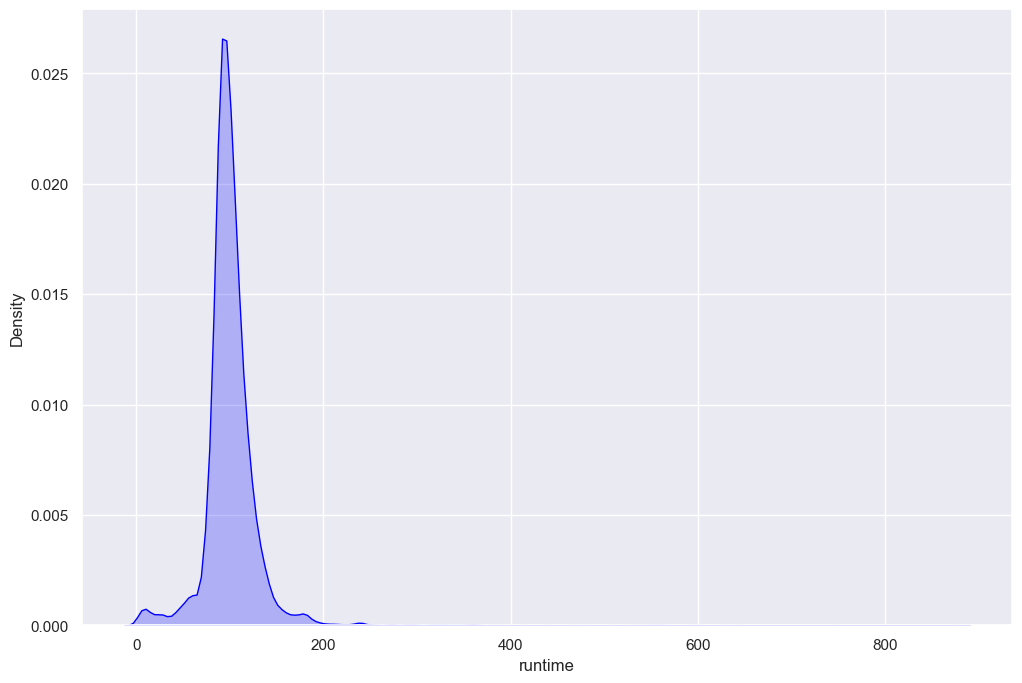

In [21]:
#Plot the Runtime
sns.set(style="darkgrid", )
sns.kdeplot(data=imdb_df['runtime'], shade=True, color='blue')

In [22]:
# Describe the runtime 
imdb_df['runtime'].describe()

count    15189.000000
mean       100.312331
std         31.061707
min          1.000000
25%         89.000000
50%         98.000000
75%        109.000000
max        877.000000
Name: runtime, dtype: float64

### Genres

The most frequently seen genres (Modal genres)

In [23]:
def feature_frequency(df, column):
    """
    Function to count the number of occurences of metadata such as genre
    Parameters
    
    -------
        
    """
    # Creat a dict to store values
    df = df.dropna(axis=0)
    genre_dict = {f'{column}': list(),
                 'count': list(),}
    # Retrieve a list of all possible genres
    print('retrieving features...')
    for movie in range(len(df)):
        gens = df[f'{column}'].iloc[movie].split('|')
        for gen in gens:
            if gen not in genre_dict[f'{column}']:
                genre_dict[f'{column}'].append(gen)
    # count the number of occurences of each genre
    print('counting...')
    for genre in genre_dict[f'{column}']:
        count = 0
        for movie in range(len(df)):
            gens = df[f'{column}'].iloc[movie].split('|')
            if genre in gens:
                count += 1
        genre_dict['count'].append(count)
        
        # Calculate metrics
    data = pd.DataFrame(genre_dict)
    print('done!')
    return data
genres = feature_frequency(movies_df, 'genres')

retrieving features...
counting...
done!


In [25]:
def feature_count(df, column):
    plt.figure(figsize=(10,6))
    # Define a list of colors for each bar
    colors = ['red', 'green', 'blue', 'yellow', 'purple'] # Add or modify colors as needed
    ax = sns.barplot(y=df[f'{column}'], x=df['count'], palette=colors, orient='h')
    plt.title(f'Number of Movies Per {column}', fontsize=14)
    plt.ylabel(f'{column}')
    plt.xlabel('Count')
    plt.show()

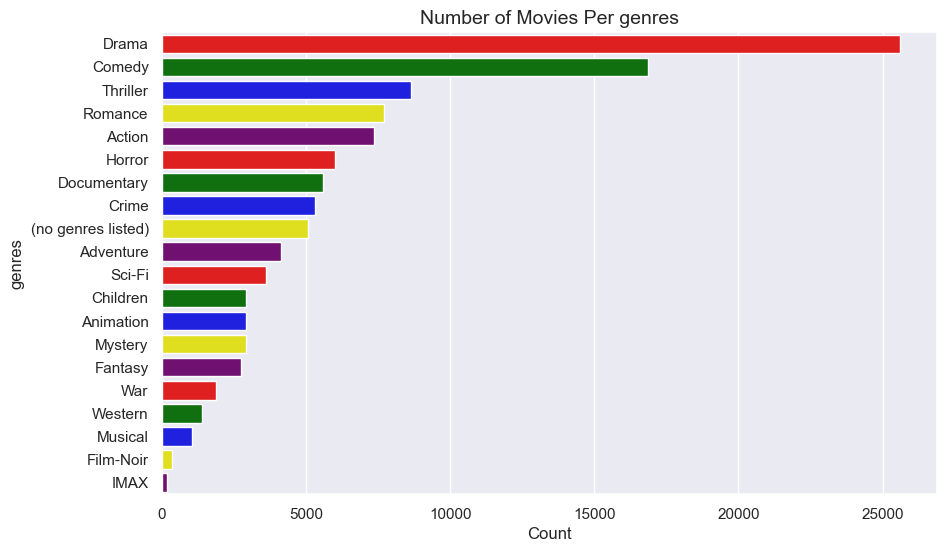

In [26]:
feature_count(genres.sort_values(by = 'count', ascending=False), 'genres')

While the provided graph displays the most prevalent genres in the database, it doesn't provide insight into the popularity or likability of each genre. Instead, let's shift our focus to analyzing the most popular movies from a specific era based on critics' reviews. This approach will help us understand the reception and acclaim of movies within that time period.

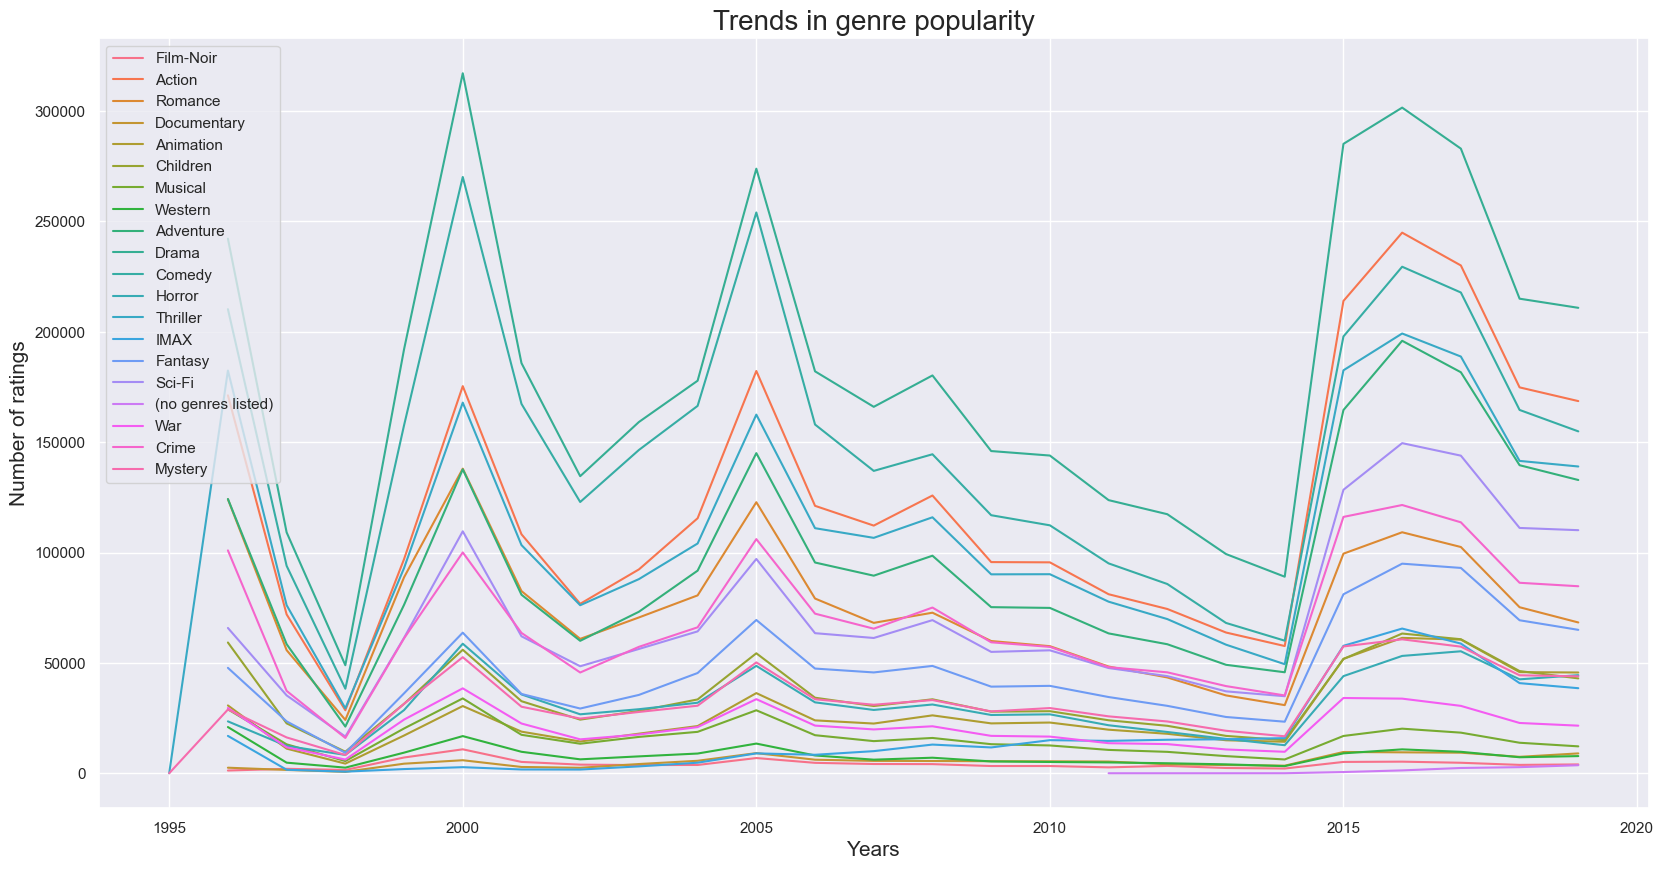

In [27]:
def most_watched(input_df):  
    """"
    This function creates a plot showing the popularity of each genre 
    over the last 50 years.
    
    """   
    # Create a copy of the input dataframe and merge it to the movies dataframe
    df = input_df.copy()
    df = df.merge(movies_df,on='movieId',how='left')
    
    # Create an empty dataframe
    b = pd.DataFrame()
    
    # Extract the timestamps and genres 
    timestamps = [timestamp for timestamp in df.timestamp]
    all_genres = set(','.join([genres.replace('|',',') for genres in df.genres]).split(','))
    
    # Get the number of ratings for each genre for each year since 1970
    for index,genre in enumerate(all_genres):
        a = pd.Series([int((timestamps[i]/31536000)+1970) for i,x in enumerate(df.genres) if genre in x])
        a = a.value_counts()
        b = pd.concat([b,pd.DataFrame({genre:a})],axis=1)
    
    # Plot the trends for each genre on the same line graph 
    plt.figure(figsize=(20,10))
    plot = sns.lineplot(data=b, dashes=False)
      
    # Add plot labels
    plt.title('Trends in genre popularity',fontsize=20)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Number of ratings', fontsize=15)
    
    plt.show()
    
    return

most_watched(train_df)

### Release Year

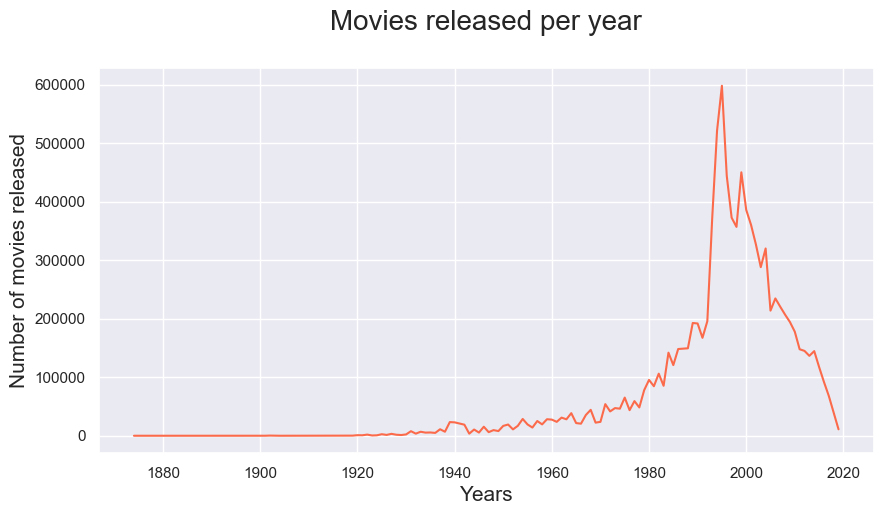

In [28]:
# Extract the release year fron the movie titles
ratings['release_year'] = ratings.title.map(lambda x: re.findall('\d\d\d\d', x))
ratings.release_year = ratings.release_year.apply(lambda x: np.nan if not x else int(x[-1]))
years =  pd.DataFrame(ratings.groupby(['release_year'])['title'].count())
years.rename(columns={'title':'movies released'}, inplace=True)

# Plot the number of movies released per year
plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years, dashes=False, legend=False, palette='Reds_r')

# Add figure labels
plt.xlabel('Years', fontsize=15)
plt.ylabel('Number of movies released', fontsize=15)
plt.title('Movies released per year\n', fontsize=20)

plt.show() 

### Directors

In [29]:
def count_directors(df, count = 10):
    
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)
directors = count_directors(imdb_df)

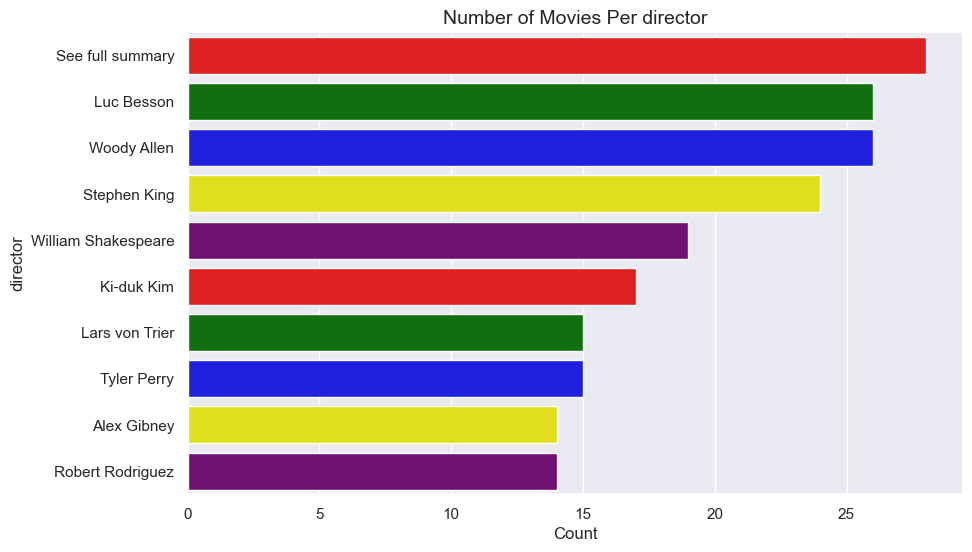

In [30]:
feature_count(directors.head(10), 'director')

Create a dataset specifically designed for the development of word clouds and corpora.

In [31]:
df = imdb_df[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies_df[['movieId', 'genres', 'title']], on='movieId', how='inner')
df['year'] = df['title'].str.extract(r"\((\d+)\)", expand=False)

In [32]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces 
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes 
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])
df['title_cast'] = df['title_cast'].apply(lambda x: " ".join(x))


# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))
df.head()

,movieId,title_cast,director,plot_keywords,genres,title,year
0,1,tomhanks timallen donrickles,johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995),1995
1,2,robinwilliams jonathanhyde kirstendunst,jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995),1995
2,3,waltermatthau jacklemmon sophialoren,markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995),1995
3,4,whitneyhouston angelabassett lorettadevine,terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995),1995
4,5,stevemartin dianekeaton martinshort,alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995),1995


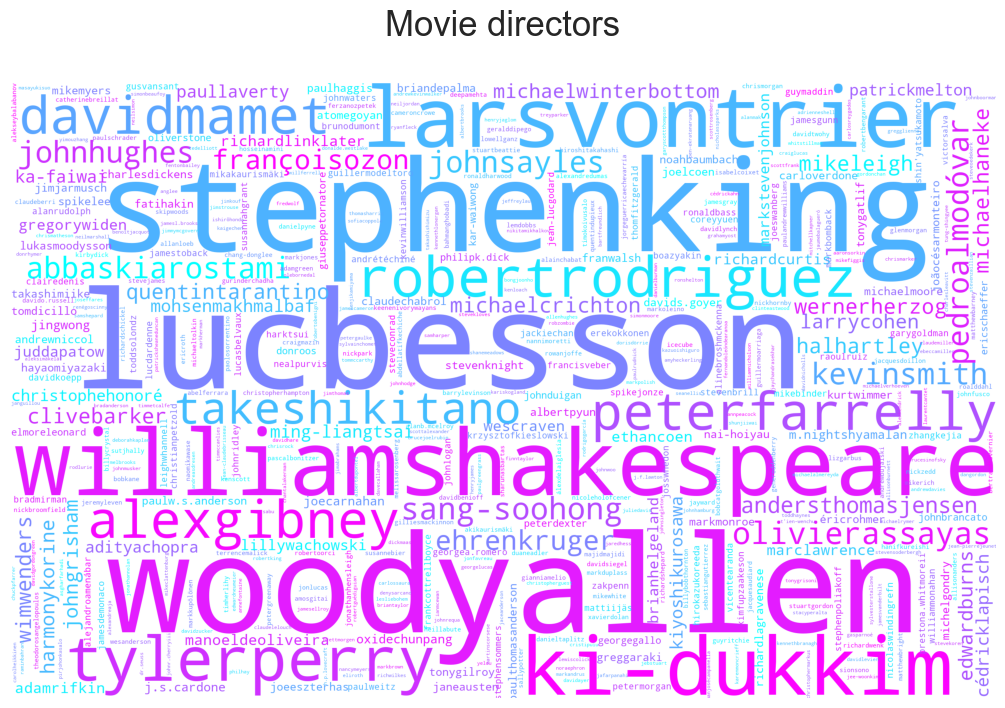

In [33]:
def wordcloud_generator(df, column):  
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # List of words that should be removed 
    removed = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in removed]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
            
    # Pair the keywords with their frequencies
    for word, word_freq in keyword_counts.items():
        keyword_pair.append((word, word_freq))
        
    # Sort the keywords according to their frequencies
    keyword_pair.sort(key=lambda x: x[1], reverse=True)
    
    # Prepare the data for word cloud generation
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a word cloud using the top 2000 keywords with modified colors
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='white',  # Change the background color here
                          colormap='cool',  # Change the colormap for the word cloud here
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0).generate_from_frequencies(words)

    return wordcloud 

# Generate a WordCloud using the movie directors  
directorc = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directorc) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()

The established recognition of Lucbesson, Stephen King, Woody Allen, Ki-dukkim, and William Shakespeare as prominent directors is primarily based on the number of movies they have directed in the database. It should be noted that while William Shakespeare and Stephen King are renowned authors rather than directors, their literary works have been widely adapted into numerous movies.

In [35]:
def count_directors(df, count = 10):
    
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)
directors = count_directors(imdb_df)

In [36]:
def dir_mean(df):
    df.set_index('director', inplace=True)

    direct_ratings = []
    #eda_df.merge(imdb_df, on='movieID, how='left')
    #join_df = df_a.merge(df_b, on='mukey', how='left')


    directors_eda = eda_df.merge(imdb_df, on = 'movieId', how = 'left')
    for director in df.index:
        rating = round(directors_eda[directors_eda['director']==director]['rating'].mean(),2)
        direct_ratings.append(rating)
    df['mean_rating'] = direct_ratings
    return df.sort_values('mean_rating', ascending = False)

In [37]:
directors = dir_mean(directors)

In [38]:
directors.head()

,count,mean_rating
director,,
Stephen King,24,4.05
Quentin Tarantino,10,3.94
John Sayles,11,3.93
Ki-duk Kim,17,3.89
Pedro Almodóvar,11,3.85


In [39]:
def feat_popularity(df, title='feat'):
    """
    Plots the mean rating per director.
    """
    plt.figure(figsize=(10, 6))
    plot_data = df.copy()
    mean = plot_data['mean_rating'].mean()
    min_ = plot_data['mean_rating'].min()
    max_ = round(plot_data['mean_rating'].max(), 2)
    
    # Define a list of colors for each bar
    colors = ['red', 'green', 'blue', 'yellow', 'purple']  # Modify the colors as desired
    
    sns.barplot(y=plot_data.index, x=plot_data['mean_rating'], order=plot_data.index, orient='h', palette=colors)
    plt.axvline(x=mean, label=f'mean {round(mean, 1)}', color='black', lw=1, ls='--')
    plt.axvline(x=min_, label=f'min {round(min_, 1)}', color='#4D17A0', lw=1, ls='--')
    plt.axvline(x=max_, label=f'max {max_}', color='#4DA017', lw=1, ls='--')
    plt.title(f'Mean Rating Per {title}', fontsize=14)
    plt.ylabel(f'{title}')
    plt.xlabel('Mean Rating')
    plt.legend(loc='lower center')
    plt.show()

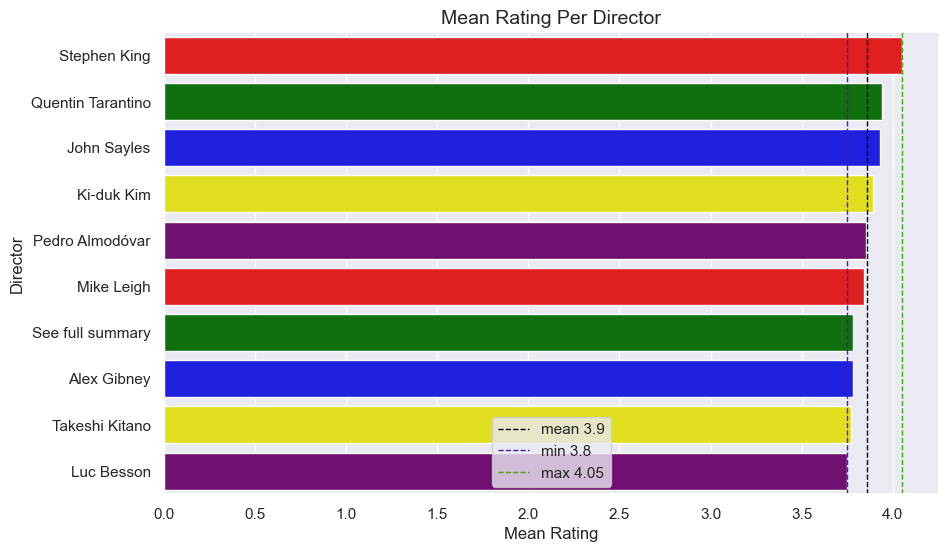

In [40]:
feat_popularity(directors.head(10), 'Director')

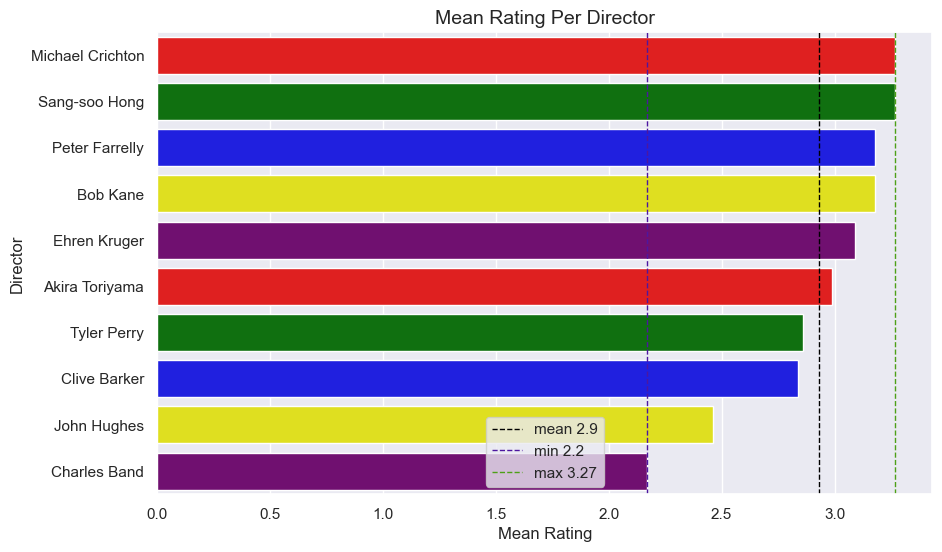

In [41]:
feat_popularity(directors.tail(10), 'Director')

### Actors

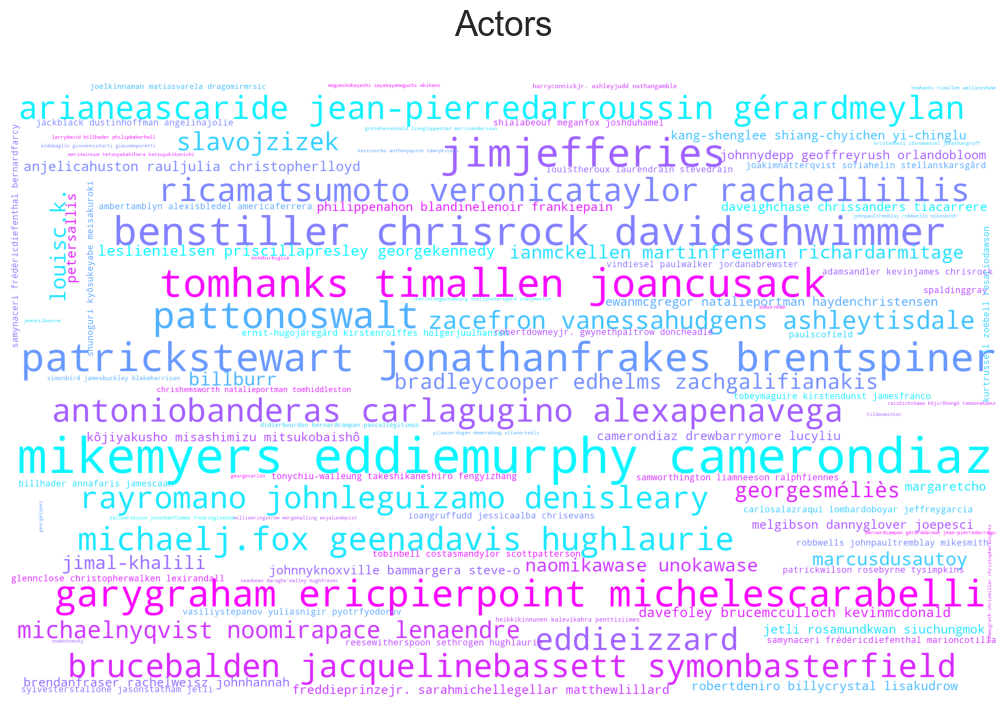

In [42]:
actors = wordcloud_generator(df, 'title_cast')

# plot the WordCloud                        
f = plt.figure(figsize=(20, 8)) 
plt.imshow(actors) 
plt.axis('off') 
plt.title('Actors\n', fontsize=25)
plt.show()

### Plot keywords

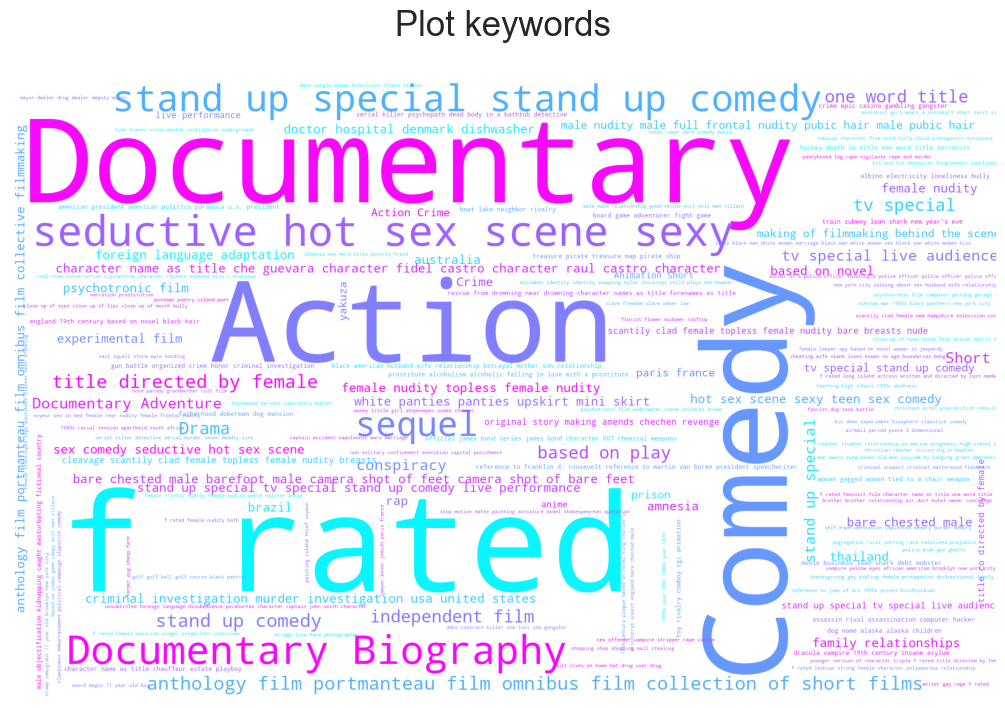

In [43]:
# Plot wordcloud
plot_keywords = wordcloud_generator(df, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()

<a id="six"></a>
## 6. Modelling
<a href=#cont>Back to Table of Contents</a>

<a id="seven"></a>
## 7. Feature Engineering
<a href=#cont>Back to Table of Contents</a>

<a id="eight"></a>
## 8. Model Training and Evaluation
<a href=#cont>Back to Table of Contents</a>

<a id="nine"></a>
## 9. Model Testing
<a href=#cont>Back to Table of Contents</a>

<a id="ten"></a>
## 10. Saving Model for Kaggle Submission
<a href=#cont>Back to Table of Contents</a>

<a id="eleven"></a>
## 11. Saving Model for Streamlit App
<a href=#cont>Back to Table of Contents</a>

<a id="twelve"></a>
## 12. Conclusion
<a href=#cont>Back to Table of Contents</a>

<a id="thirteen"></a>
## 13. Recommendations
<a href=#cont>Back to Table of Contents</a>

<a id="fourteen"></a>
## 14. Reference Links
<a href=#cont>Back to Table of Contents</a>